In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16

metadata_path = "butterfly.csv"
metadata = pd.read_csv(metadata_path)
metadata = metadata[['filename', 'label']]

images_base_path = "./imgs/"

# Додаємо колонку з повними шляхами до файлів
metadata['filename'] = metadata['filename'].apply(lambda x: os.path.join(images_base_path, x))

# Вибір класів (щоб обмежити кількість)
selected_classes = metadata['label'].value_counts().head(5).index.tolist()
metadata = metadata[metadata['label'].isin(selected_classes)]

# Розподіл на навчальну, валідаційну та тестову вибірки
train_df = metadata.sample(frac=0.6, random_state=42)
test_val_df = metadata.drop(train_df.index)
val_df = test_val_df.sample(frac=0.5, random_state=42)
test_df = test_val_df.drop(val_df.index)

# Перевірка
print("Train:", len(train_df), "Validation:", len(val_df), "Test:", len(test_df))
print(selected_classes)
print(metadata['filename'])

Train: 320 Validation: 107 Test: 107
['MOURNING CLOAK', 'SLEEPY ORANGE', 'ATALA', 'BROWN SIPROETA', 'CRECENT']
2          ./imgs/Image_3.jpg
8          ./imgs/Image_9.jpg
29        ./imgs/Image_30.jpg
71        ./imgs/Image_72.jpg
73        ./imgs/Image_74.jpg
                ...          
6466    ./imgs/Image_6467.jpg
6468    ./imgs/Image_6469.jpg
6481    ./imgs/Image_6482.jpg
6495    ./imgs/Image_6496.jpg
6498    ./imgs/Image_6499.jpg
Name: filename, Length: 534, dtype: object


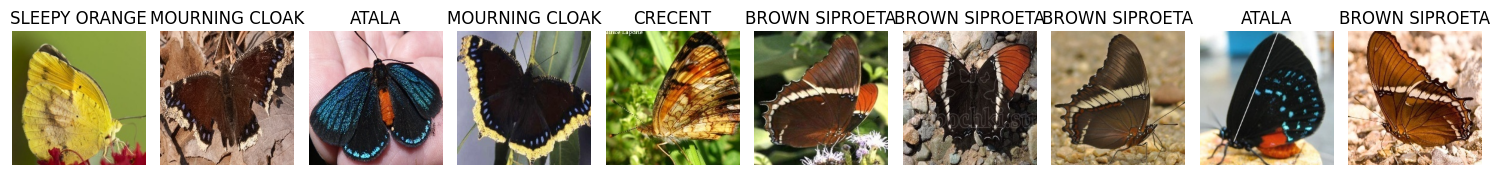

In [62]:
import matplotlib.pyplot as plt
import cv2

# Вибір перших 5 зображень із навчальної вибірки
sample_images = train_df.head(10)

# Виведення зображень і міток
plt.figure(figsize=(15, 5))
for idx, row in enumerate(sample_images.iterrows()):
    filepath = row[1]['filename']
    label = row[1]['label']
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 10, idx + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [56]:
# Генератори для зображень
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='label', target_size=(128, 128), class_mode='categorical', batch_size=32)

val_generator = datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='label', target_size=(128, 128), class_mode='categorical', batch_size=32)

test_generator = datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='label', target_size=(128, 128), class_mode='categorical', batch_size=32, shuffle=False)

Found 320 validated image filenames belonging to 5 classes.
Found 107 validated image filenames belonging to 5 classes.
Found 107 validated image filenames belonging to 5 classes.


In [57]:
#Крок 4: Модель (а) — навчання з нуля
model_scratch = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')
])

model_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_scratch = model_scratch.fit(train_generator, validation_data=val_generator, epochs=12)


Epoch 1/12
10/10 [==============================] - 4s 312ms/step - loss: 1.7567 - accuracy: 0.2500 - val_loss: 1.4671 - val_accuracy: 0.3551
Epoch 2/12
10/10 [==============================] - 3s 292ms/step - loss: 1.2854 - accuracy: 0.5094 - val_loss: 1.1825 - val_accuracy: 0.5421
Epoch 3/12
10/10 [==============================] - 3s 296ms/step - loss: 0.9606 - accuracy: 0.6500 - val_loss: 0.7988 - val_accuracy: 0.7103
Epoch 4/12
10/10 [==============================] - 3s 297ms/step - loss: 0.6459 - accuracy: 0.7750 - val_loss: 0.5581 - val_accuracy: 0.7477
Epoch 5/12
10/10 [==============================] - 3s 296ms/step - loss: 0.4607 - accuracy: 0.8250 - val_loss: 0.4250 - val_accuracy: 0.8505
Epoch 6/12
10/10 [==============================] - 3s 299ms/step - loss: 0.4875 - accuracy: 0.8281 - val_loss: 0.4451 - val_accuracy: 0.8505
Epoch 7/12
10/10 [==============================] - 3s 323ms/step - loss: 0.3268 - accuracy: 0.8969 - val_loss: 0.3497 - val_accuracy: 0.8785
Epoch 

In [58]:
#Крок 5: Модель (б) — перенесення навчання
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Заморожуємо шари

model_transfer = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')
])

model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_transfer = model_transfer.fit(train_generator, validation_data=val_generator, epochs=12)

Epoch 1/12
10/10 [==============================] - 12s 1s/step - loss: 1.5975 - accuracy: 0.4313 - val_loss: 0.6205 - val_accuracy: 0.8037
Epoch 2/12
10/10 [==============================] - 11s 1s/step - loss: 0.5908 - accuracy: 0.7875 - val_loss: 0.5498 - val_accuracy: 0.8131
Epoch 3/12
10/10 [==============================] - 11s 1s/step - loss: 0.3485 - accuracy: 0.8719 - val_loss: 0.3275 - val_accuracy: 0.8785
Epoch 4/12
10/10 [==============================] - 11s 1s/step - loss: 0.1789 - accuracy: 0.9406 - val_loss: 0.3174 - val_accuracy: 0.8598
Epoch 5/12
10/10 [==============================] - 11s 1s/step - loss: 0.1205 - accuracy: 0.9844 - val_loss: 0.2340 - val_accuracy: 0.8972
Epoch 6/12
10/10 [==============================] - 11s 1s/step - loss: 0.1156 - accuracy: 0.9656 - val_loss: 0.2318 - val_accuracy: 0.9065
Epoch 7/12
10/10 [==============================] - 12s 1s/step - loss: 0.0763 - accuracy: 0.9812 - val_loss: 0.1973 - val_accuracy: 0.9065
Epoch 8/12
10/10 [==

4/4 [==============================] - 3s 620ms/step - loss: 0.0550 - accuracy: 0.9720
Model from scratch: Test Accuracy = 0.92
Transfer learning: Test Accuracy = 0.97


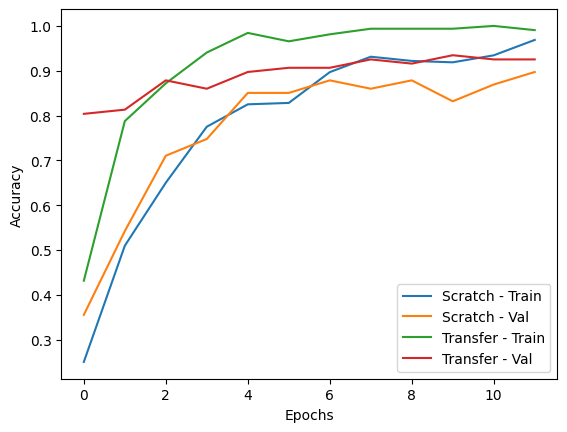

In [59]:
# Тестування обох моделей
test_loss_scratch, test_acc_scratch = model_scratch.evaluate(test_generator)
test_loss_transfer, test_acc_transfer = model_transfer.evaluate(test_generator)

print(f"Model from scratch: Test Accuracy = {test_acc_scratch:.2f}")
print(f"Transfer learning: Test Accuracy = {test_acc_transfer:.2f}")

# Графіки точності
plt.plot(history_scratch.history['accuracy'], label='Scratch - Train')
plt.plot(history_scratch.history['val_accuracy'], label='Scratch - Val')
plt.plot(history_transfer.history['accuracy'], label='Transfer - Train')
plt.plot(history_transfer.history['val_accuracy'], label='Transfer - Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()